In [1]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from MHrank import MH_sample 
from eprank import exprop
import pandas
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [2]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
games = data['G'] - 1
num_players = W.shape[0]
num_games = games.shape[0]

# MCMC sampling (this may take a minute)

In [4]:
# number of iterations -- the more the better!
num_its = 2000
# run the sampler for several proposal std (treated as "var" variable here meaning proposal std)
proposal_stds = [0.1, 0.5, 0.7]
acceptance_results = {}

for p in proposal_stds:
    # set seed for reproducibility between runs
    np.random.seed(0)
    print(f"Running MH sampler with proposal_std = {p} for {num_its} iterations...")
    skill_samples, accept_rates = MH_sample(games, num_players, num_its, proposal_std=p, return_acceptance=True)
    overall_accept = np.mean(accept_rates)
    acceptance_results[p] = overall_accept
    print(f"  -> Overall acceptance rate: {overall_accept:.3f}")

print('\nSummary of acceptance rates:')
for p, acc in acceptance_results.items():
    print(f"proposal_std={p:0.3f} -> average acceptance rate = {acc:.3f}")

# keep skill_samples from the last run for downstream plotting


Running MH sampler with proposal_std = 0.1 for 2000 iterations...


100%|██████████| 2000/2000 [02:29<00:00, 13.37it/s]


  -> Overall acceptance rate: 0.869
Running MH sampler with proposal_std = 0.5 for 2000 iterations...


100%|██████████| 2000/2000 [03:08<00:00, 10.58it/s]


  -> Overall acceptance rate: 0.503
Running MH sampler with proposal_std = 0.7 for 2000 iterations...


100%|██████████| 2000/2000 [03:05<00:00, 10.78it/s]

  -> Overall acceptance rate: 0.406

Summary of acceptance rates:
proposal_std=0.100 -> average acceptance rate = 0.869
proposal_std=0.500 -> average acceptance rate = 0.503
proposal_std=0.700 -> average acceptance rate = 0.406


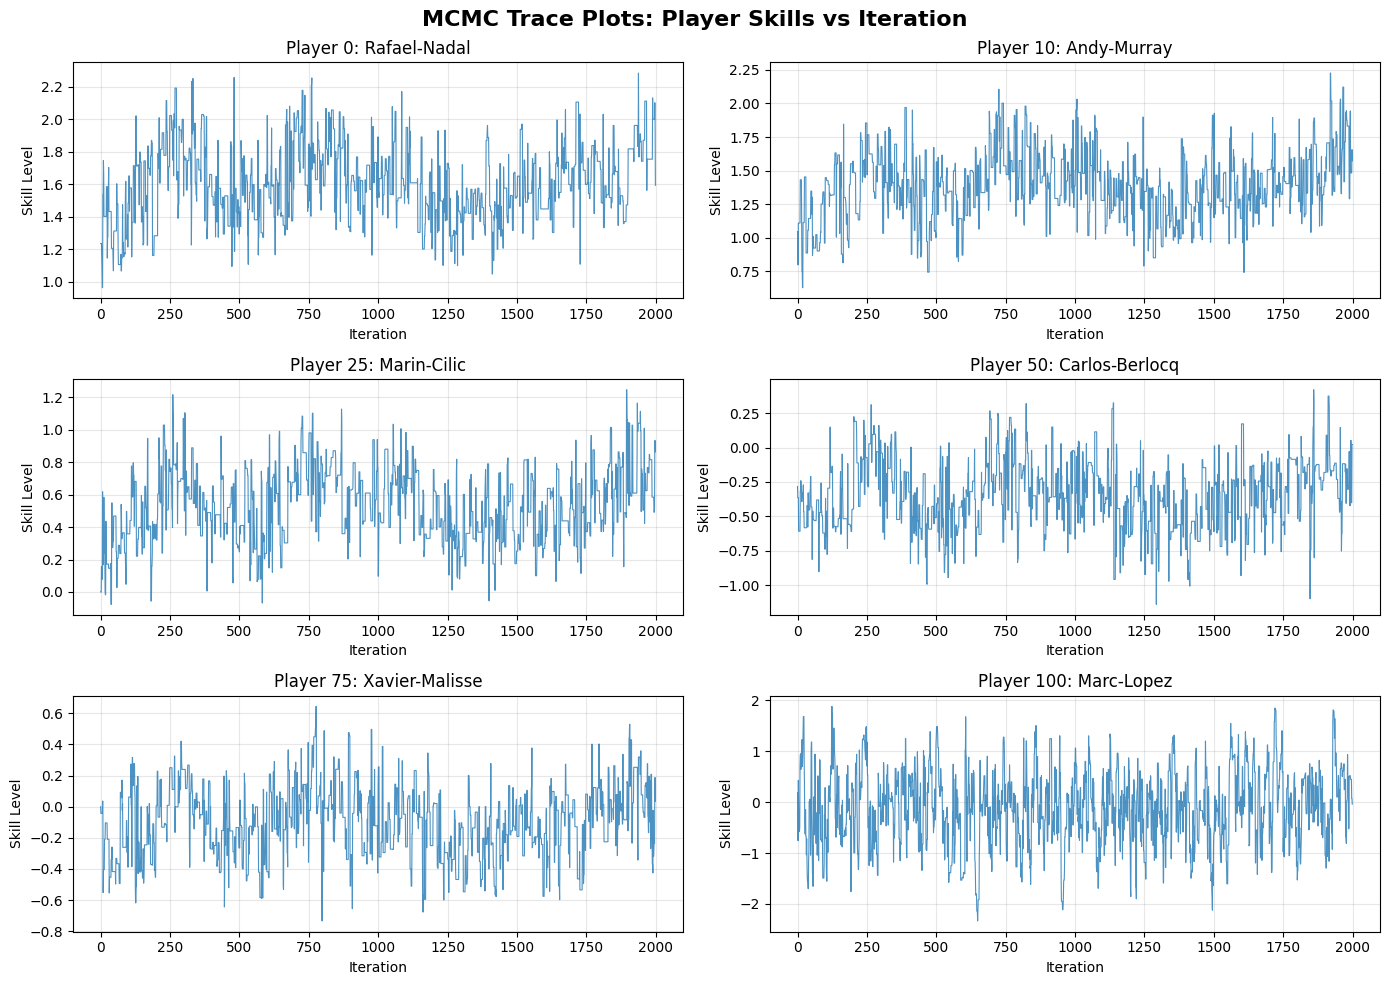

Summary Statistics for Selected Players:
------------------------------------------------------------
Player   0 (Rafael-Nadal        ): mean=  1.607, std= 0.231
Player  10 (Andy-Murray         ): mean=  1.390, std= 0.251
Player  25 (Marin-Cilic         ): mean=  0.535, std= 0.228
Player  50 (Carlos-Berlocq      ): mean= -0.345, std= 0.251
Player  75 (Xavier-Malisse      ): mean= -0.097, std= 0.227
Player 100 (Marc-Lopez          ): mean= -0.109, std= 0.745


In [5]:
# Plot sampled skills for selected players as a function of iteration
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('MCMC Trace Plots: Player Skills vs Iteration', fontsize=16, fontweight='bold')

# Select 6 diverse players to plot
player_indices = [0, 10, 25, 50, 75, 100]

for idx, ax in enumerate(axes.flat):
    player_id = player_indices[idx]
    ax.plot(skill_samples[player_id, :], linewidth=0.8, alpha=0.8)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Skill Level')
    ax.set_title(f'Player {player_id}: {W[player_id][0]}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display summary statistics
print("Summary Statistics for Selected Players:")
print("-" * 60)
for player_id in player_indices:
    mean_skill = np.mean(skill_samples[player_id, :])
    std_skill = np.std(skill_samples[player_id, :])
    player_name = W[player_id][0] if isinstance(W[player_id], np.ndarray) else W[player_id]
    print(f"Player {player_id:3d} ({player_name:20s}): mean={mean_skill:7.3f}, std={std_skill:6.3f}")


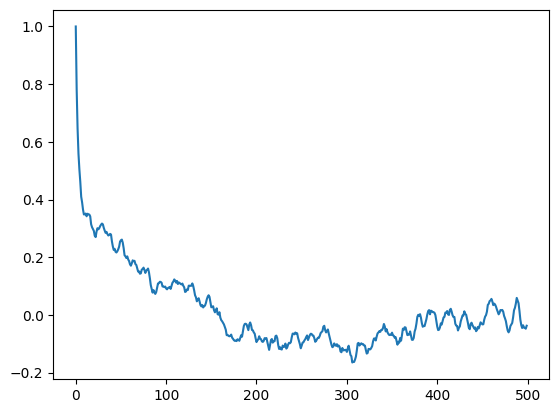

In [6]:
# plotting the autocorrelation function for player i
i = 0
autocor = np.zeros(500)
for t in range(500):
    autocor[t]=pandas.Series.autocorr(pandas.Series(skill_samples[i,:]),lag=t)
plt.plot(autocor)

# Expectation propagation ranking

In [10]:
# run message passing algorithm, returns mean and variance for each player
ep_mean, ep_var = exprop(games, num_players, num_its = 3).T